# IMPORT LIBRARIES

In [26]:
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from skimage.filters import prewitt_h,prewitt_v
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from random import sample

# GET DATA

In [2]:
def get_data_test(val_split = False, val_size = 0.3, zca_whitening = False):
    path = '../catchafish/data'
    batch_size = 1500
    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (128, 128),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int,
                                    color_mode = 'grayscale')
    X = dir_iterator[0][0] / 255
    y = dir_iterator.labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening,
                                              rotation_range = 5,
                                              width_shift_range = 0.3,
                                              height_shift_range = 0.3,
                                              shear_range = 0.3,
                                              zoom_range = 0.3,
                                              horizontal_flip = True,
                                              fill_mode = 'nearest')
    
    image_data_generator.fit(X_train)

    extended_output = []
    for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size):
        extended_output.append(images)
        if len(extended_output) == 5:
            break

    X_train = extended_output[0][0]
    y_train = extended_output[0][1]

    for data_tuple in extended_output[1:]:
        X_train = np.concatenate((X_train, data_tuple[0]), axis = 0)
        y_train = np.concatenate((y_train, data_tuple[1]), axis = 0)

    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [3]:
#loading data in grayscale
X_train, X_test, y_train, y_test = get_data_test()

Found 1305 images belonging to 11 classes.


/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
#resize dataset -> each image (128,128)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2]*X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2]*X_test.shape[3])

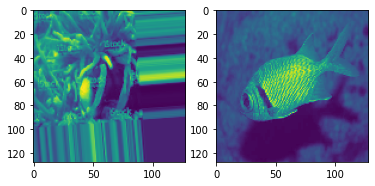

In [10]:
#plot transformed train image vs test image
plt.subplot(1,2,1)
plt.imshow(X_train[4000])
plt.subplot(1,2,2)
plt.imshow(X_test[0])

# Extracting features 

In [17]:
#fonctions for extracting features
def extracting_features(img):
    #calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(img)
    return edges_prewitt_horizontal

def extracting_features_dataset(X):
    X_features= []
    for x in X:
        img_features = extracting_features(x)
        X_features.append(img_features)
    X_features= np.array(X_features)
    X_features = X_features.reshape(X_features.shape[0],X_features.shape[1]*X_features.shape[2])
    return X_features

In [19]:
X_train_features = extracting_features_dataset(X_train)
X_test_features = extracting_features_dataset(X_test)

# Processing data for SVC

In [22]:
mmscaler = MinMaxScaler()
X_train_scaled = mmscaler.fit_transform(X_train_features)
X_test_scaled = mmscaler.transform(X_test_features)


#  Grid search for SVC 

In [32]:
sgd_model = SGDClassifier(max_iter=1000)

In [33]:
sgd_model.fit(X_train_scaled, y_train)

/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
sgd_model.score(X_test_scaled, y_test)

0.11734693877551021

In [35]:
sgd_param_grid = {"loss": ["hinge","log"], "penalty" : ["l2", "l1", "elasticnet"], "alpha" : [0.01, 0.001, 0.0001] }

In [38]:
sgd_gridsearch = GridSearchCV(estimator = sgd_model,
                              param_grid = sgd_param_grid, cv = 5,
                              scoring = 'accuracy',
                              verbose = True)

In [ ]:
sgd_gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/lil